In [11]:
import warnings
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pointbiserialr
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, cross_val_score
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
pd.set_option("max_r", 100)

In [2]:
# LIWC features
df_19_liwc = pd.read_csv("LIWC2015-NeurIPS19txt.csv")
df_21_liwc = pd.read_csv("LIWC2015-NeurIPS21txt.csv")

# y values
df_19_ys = pd.read_csv("NeurIPS19-clean.csv")
df_21_ys = pd.read_csv("NeurIPS21-clean.csv")

# All x and y dataframe
df_19_ratings = df_19_liwc.merge(df_19_ys[["ratings","Filename"]],how="inner")
df_19_ratings_X = df_19_ratings[df_19_ratings.columns[~df_19_ratings.columns.isin(["ratings","Filename"])]]
df_19_ratings_y = df_19_ratings["ratings"]

df_19_decision = df_19_liwc.merge(df_19_ys[["decision","Filename"]],how="inner")
df_19_decision_X = df_19_decision[df_19_decision.columns[~df_19_decision.columns.isin(["decision","Filename"])]]
df_19_decision_y = df_19_decision["decision"]

df_21_ratings = df_21_liwc.merge(df_21_ys[["ratings","Filename"]],how="inner")
df_21_ratings_X = df_21_ratings[df_21_ratings.columns[~df_21_ratings.columns.isin(["ratings","Filename"])]]
df_21_ratings_y = df_21_ratings["ratings"]

df_21_decision = df_21_liwc.merge(df_21_ys[["decision","Filename"]],how="inner")
df_21_decision_X = df_21_decision[df_21_decision.columns[~df_21_decision.columns.isin(["decision","Filename"])]]
df_21_decision_y = df_21_decision["decision"]

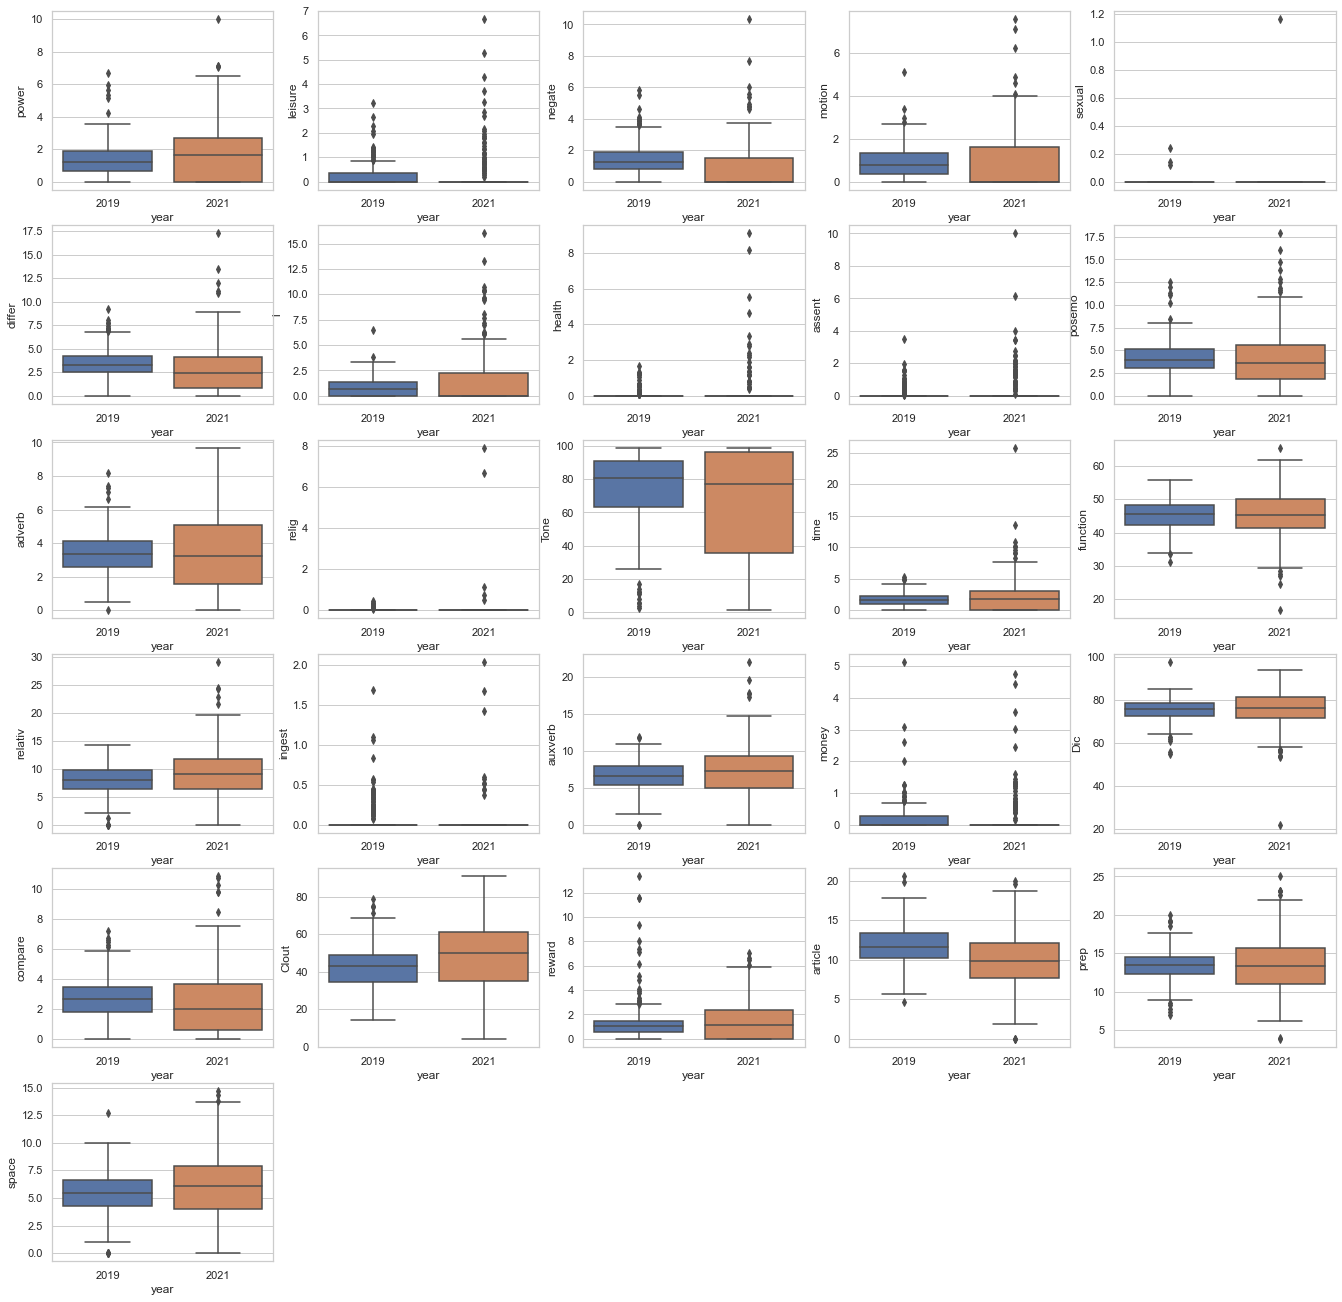

In [3]:
# Distribution for selected LIWC features in NIPS19 vs. NIPS21
selected_19_v = set(['negate', 'Clout', 'health', 'adverb', 'leisure', 'money', 'motion', 'reward', 'relig', 'prep', 'power', 'sexual', 'assent', 'ingest'])
selected_21_v = set(['function', 'auxverb', 'prep', 'i', 'Clout', 'relativ', 'article', 'space', 'differ', 'time', 'Tone', 'sexual', 'health', 'compare', 'Dic', 'posemo'])
selected_all_v = list(set.union(selected_19_v,selected_21_v))
df_19_ratings_v = df_19_ratings_X.loc[:,selected_all_v]
df_19_ratings_v["year"] = "2019"
df_21_ratings_v = df_21_ratings_X.loc[:,selected_all_v]
df_21_ratings_v["year"] = "2021"
df_ratings_all_v = pd.concat([df_19_ratings_v,df_21_ratings_v],axis=0)

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(6, 5, figsize=(23, 23))
for r in range(6):
    for c in range(5):
        if r == 5:
            if c == 0:
                sns.boxplot(ax=axes[r, c], data=df_ratings_all_v, x='year', y=selected_all_v[-1])
            else:
                axes[r, c].axis('off')
        else:
            sns.boxplot(ax=axes[r, c], data=df_ratings_all_v, x='year', y=selected_all_v[r*5+c])
plt.show()


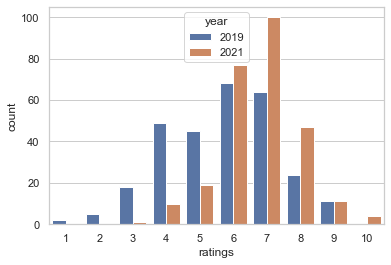

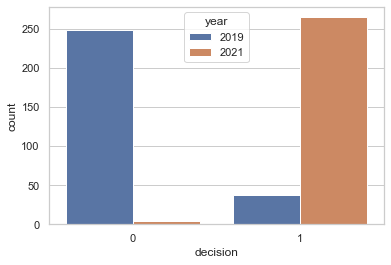

In [4]:
# Histogram of ratings
df_19_ratings_y_pic = pd.DataFrame(df_19_ratings_y)
df_19_ratings_y_pic["year"] = "2019"
df_21_ratings_y_pic = pd.DataFrame(df_21_ratings_y)
df_21_ratings_y_pic["year"] = "2021"
ratings_hist = pd.concat([df_19_ratings_y_pic,df_21_ratings_y_pic],axis = 0)
ratings_hist = ratings_hist.reset_index()
ax = sns.countplot(data=ratings_hist, x="ratings", hue="year")
plt.show()
# Histogram of decision
df_19_decision_y_pic = pd.DataFrame(df_19_decision_y)
df_19_decision_y_pic["year"] = "2019"
df_21_decision_y_pic = pd.DataFrame(df_21_decision_y)
df_21_decision_y_pic["year"] = "2021"
decision_hist = pd.concat([df_19_decision_y_pic,df_21_decision_y_pic],axis = 0)
decision_hist = decision_hist.reset_index()
ax = sns.countplot(data=decision_hist, x="decision",hue="year")
plt.show()

In [5]:
# some utils
# linear model std
def beta_std(lm, X, y):
    N = len(X)
    p = len(X.columns) + 1
    X_with_intercept = np.empty(shape=(N, p), dtype=np.float64)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = X.values
    # Note: first entry of beta_hat is beta_0
    tmp = [lm.intercept_]+lm.coef_
    beta_hat = np.array(tmp).reshape(-1,1)
    y_hat = lm.predict(X)
    residuals = y.values - y_hat
    residuals = residuals.reshape(-1,1)
    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
    stds = []
    for i in range(p):
        standard_error = var_beta_hat[i, i] ** 0.5
        stds.append(standard_error)
    beta_hat.flatten()
    return stds, beta_hat

# hypothesis test
# null: two coefficients of a same feature are the same in two models
def cmp_coeff(coeffs):
    print("Compare coefficients test...")
    d = dict()
    for coeff in coeffs:
        feature_name = coeff
        beta1,beta2,se1,se2 = coeffs[coeff]
        z_score = (beta1 - beta2) / ((se1**2 + se2**2) ** 0.5)
        # two tailed z test
        p_val = 2*(min(norm.cdf(z_score),1 - norm.cdf(z_score)))
        if p_val < 0.001:
            d[coeff] = (p_val,"***") # significant
        elif p_val < 0.01:
            d[coeff] = (p_val,"**")
        elif p_val < 0.05:
            d[coeff] = (p_val,"*")
        elif p_val < 0.1:
            d[coeff] = (p_val,".")
        else:
            d[coeff] = (p_val," ")
        #print("p-value of",coeff,"is",p_val)
    return d

# hypothesis test
# null: coeffient is greater than zero
def zero_slope(coeffs):
    print("Zero slope test...")
    d = dict()
    for coeff in coeffs:
        feature_name = coeff
        beta,se = coeffs[coeff]
        z_score = (beta - 0) / se
        # two tailed z test
        p_val = 1 - norm.cdf(z_score) # right-tailed
        if p_val < 0.001:
            d[coeff] = (p_val,"***") # significant
        elif p_val < 0.01:
            d[coeff] = (p_val,"**")
        elif p_val < 0.05:
            d[coeff] = (p_val,"*")
        elif p_val < 0.1:
            d[coeff] = (p_val,".")
        else:
            d[coeff] = (p_val," ")
        #print("p-value of",coeff,"is",p_val)
    return d


# Build the best ratings model
def ratings(X,y,rs=42):
    feature_names = list(X.columns[~X.columns.isin(["Filename"])])
    scaler = MinMaxScaler()
    X_new = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, random_state=rs)
    X_train = pd.DataFrame(X_train, columns = feature_names)
    X_test = pd.DataFrame(X_test, columns = feature_names)
    
    # rank permutation importance on train dataset
    lasso_alpha = 0.0001
    lasso_max_iter = 10000
    clf = Lasso(alpha=lasso_alpha,max_iter=lasso_max_iter).fit(X_train,y_train)
    result = permutation_importance(clf, X_train, y_train, random_state=rs)
    importance = result.importances_mean
    lr_importances = pd.Series(importance, index=feature_names)
    lr_importances = lr_importances.sort_values(ascending=False)
    sorted_features = list(lr_importances.index)
    scores = []
    
    # cross-validation
    for i in range(len(sorted_features)-1):
        X_train_cv = X_train.loc[:,sorted_features[:i+1]]
        y_train_cv = y_train
        lm = Lasso(alpha=lasso_alpha,max_iter=lasso_max_iter)
        folds = KFold(n_splits = 10, shuffle = True, random_state = rs ) 
        # r^2
        score = sum(cross_val_score(lm, X_train_cv, y_train_cv, scoring='r2', cv=folds))/5
        scores.append(score)
    plt.plot(range(1,len(sorted_features)),scores)
    plt.xticks(range(1,len(sorted_features)+1,5)) 
    plt.title("r^2 in Cross Validation vs. number of important features")
    plt.grid()
    plt.show()
    
    # Select top 25 features from CV plot, CV r^2 for 25 features around 0.37
    selected = sorted_features[:16] # 14(19), 16(21)
    print("Selected Features:", selected)
    
    # Train set merged
    train_lm = Lasso(alpha=lasso_alpha,max_iter=lasso_max_iter).fit(X_train.loc[:,selected],y_train)
    train_r2 = train_lm.score(X_train.loc[:,selected],y_train)
    print("Train r^2:",train_r2) # 0.3788(19), 0.1225(21)
    
    # Test set Validation
    test_r2 = train_lm.score(X_test.loc[:,selected], y_test)
    print("Test r^2:",test_r2) # 0.1258(19), 0.0303(21)
    
    '''
    # z-test to compare train/test coefficients
    stds_train, betas_train = beta_std(train_lm, X_train.loc[:,selected],y_train)
    stds_train, betas_train = stds_train[1:], betas_train[1:] # excluding intercept
    stds_test, betas_test = beta_std(test_lm, X_test.loc[:,selected],y_test)
    stds_test, betas_test = std_test, betas_test[1:] # excluding intercept
    coeffs = dict()
    for i in range(len(selected)):
        coeffs[selected[i]] = [betas_train[i],betas_test[i],stds_train[i],stds_test[i]] 
    sig_cmp = cmp_coeffs(coeffs)
    '''
    
    # Inference
    # report model coefficients, r^2, zero-slope significance on the whole dataset
    X_new = pd.DataFrame(X_new, columns = feature_names)
    all_lm = Lasso(alpha=lasso_alpha, max_iter = lasso_max_iter).fit(X_new.loc[:,selected],y)
    all_r2 = all_lm.score(X_new.loc[:,selected],y)
    print("Final r^2:",all_r2) # 0.3603(19), 0.1183(21)
    stds, beta_hat = beta_std(all_lm, X_new.loc[:,selected],y)
    beta = dict(zip(selected,beta_hat))
    coeffs_all = dict()
    for i in range(len(selected)):
        coeffs_all[selected[i]] = [beta_hat[i],stds[i]] 
    sig_zero = zero_slope(coeffs_all)
    
    return lasso_alpha, lasso_max_iter, train_r2, test_r2, all_r2, beta, sig_zero

# Use optimal parameters to reproduce results
#ratings(df_19_ratings_X,df_19_ratings_y,15210) # alpha = 0.005, lasso_max_iter = 10000
# selected = ['negate', 'Clout', 'health', 'adverb', 'leisure', 'money', 'motion', 'reward', 'relig', 'prep', 'power', 'sexual', 'assent', 'ingest']
# all ***, positive

#ratings(df_21_ratings_X,df_21_ratings_y,15210) # alpha = 0.0001, lasso_max_iter = 10000
# selected = ['function', 'auxverb', 'prep', 'i', 'Clout', 'relativ', 'article', 'space', 'differ', 'time', 'Tone', 'sexual', 'health', 'compare', 'Dic', 'posemo']
# all ***, positive



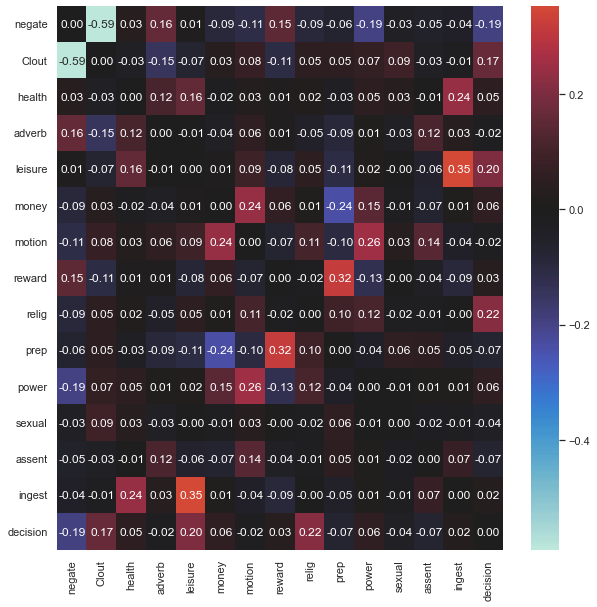

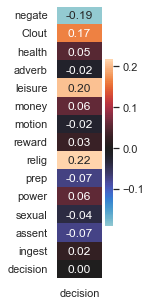

Train Acc: 0.8793774319066148
Test Acc: 0.7586206896551724


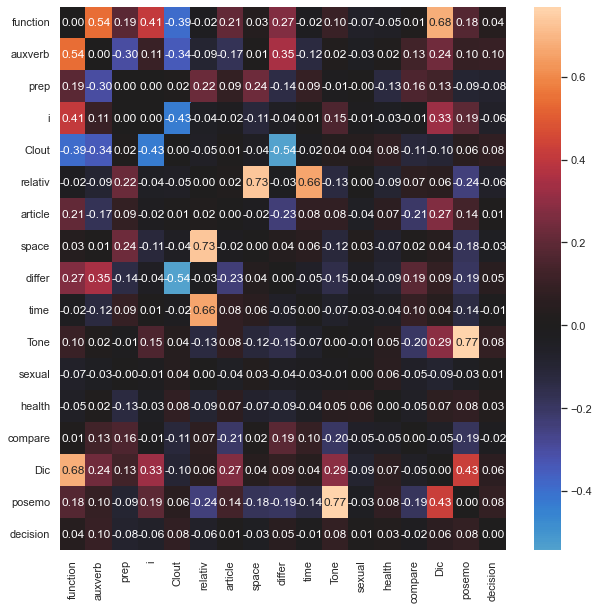

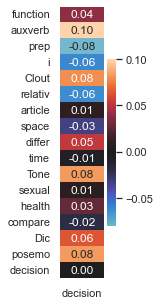

Train Acc: 0.987603305785124
Test Acc: 0.9629629629629629


In [6]:
def decision(X,y,selected,rs=42):
    feature_names = list(X.columns[~X.columns.isin(["Filename"])])
    scaler = MinMaxScaler()
    X_new = scaler.fit_transform(X)
    X_new = pd.DataFrame(X_new, columns = feature_names)
    X_new = X_new.loc[:,selected]
    
    # correlation matrix
    dim = selected + ["decision"]
    Xy = pd.concat([X_new,y],axis=1)
    M_corr = [[pointbiserialr(Xy.iloc[:,i],Xy.iloc[:,j])[0] for j in range(len(dim))] for i in range(len(dim))]
    for i in range(len(M_corr)):
        M_corr[i][i] = 0
    M_p = [[pointbiserialr(Xy.iloc[:,i],Xy.iloc[:,j])[1] for j in range(len(dim))] for i in range(len(dim))]
    # only report last row of p_val matrix (decision)
    
    for i in range(len(M_p)):
        M_corr[i][i] = 0
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(M_corr, annot=True, fmt=".2f", center=0, xticklabels=dim, yticklabels=dim)
    plt.yticks(rotation=0)
    plt.show() # whole corr matrix
    
    # last row
    plt.figure(figsize=(1,5))
    sns.heatmap(np.array([M_corr[-1][:]]).T, annot=True, fmt=".2f", center=0, \
                yticklabels=dim, xticklabels=["decision"])
    plt.yticks(rotation=0)
    plt.show()
    
    # L1 Logistic Regression
    # build a model on train 
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, random_state=rs)
    clf = LogisticRegression(penalty="l1",solver="liblinear",random_state=rs).fit(X_train, y_train)
    # report train/test accuracy
    train_acc = clf.score(X_train, y_train) # 0.8794(19),0.9876(21)
    test_acc = clf.score(X_test, y_test) # 0.7586(19),0.9630(21)
    print("Train Acc:",train_acc)
    print("Test Acc:",test_acc)
    return

selected_19 = ['negate', 'Clout', 'health', 'adverb', 'leisure', 'money', 'motion', 'reward', 'relig', 'prep', 'power', 'sexual', 'assent', 'ingest']
decision(df_19_decision_X,df_19_decision_y,selected_19)

selected_21 = ['function', 'auxverb', 'prep', 'i', 'Clout', 'relativ', 'article', 'space', 'differ', 'time', 'Tone', 'sexual', 'health', 'compare', 'Dic', 'posemo']
decision(df_21_decision_X,df_21_decision_y,selected_21)



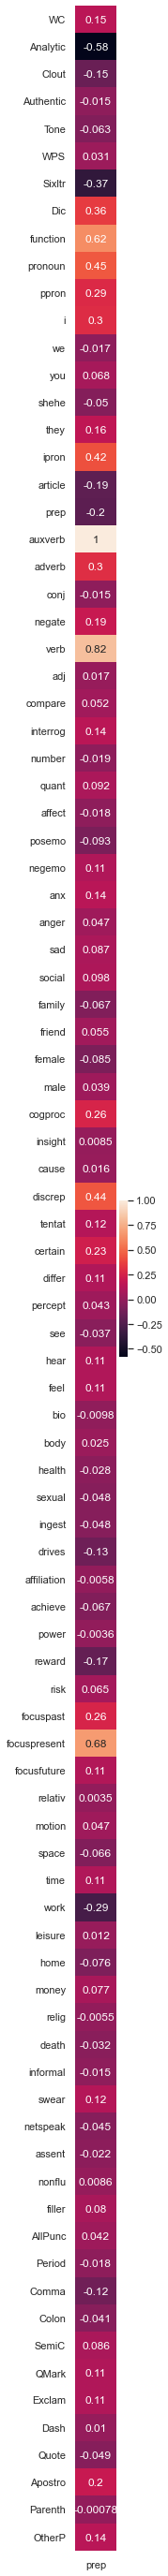

In [10]:
# corr of all features vs. prep
X = np.array(df_19_decision_X.iloc[:,1:])
C = np.corrcoef(X.T)
plt.figure(figsize=(1,50))
sns.heatmap(C[19].reshape(-1,1), annot=True, \
            yticklabels=list(df_19_decision_X.columns)[1:], xticklabels=["prep"])
plt.yticks(rotation=0)
plt.show()